<a href="https://colab.research.google.com/github/danisJIOGUE/statistics-application/blob/rodrigue/Python_Code/predict_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [243]:
!pip install pycountry_convert

In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from subprocess import check_output
from plotnine import *
from google.colab import drive
import pycountry_convert as pc
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [245]:
#Detection of the dataset'encoding
import chardet

#Loan dataset
with open("/content/drive/My Drive/Stat_App/loans.csv", 'rb') as f:
    c = f.read()
chardet.detect(c)

{'confidence': 0.7291077209623456, 'encoding': 'ISO-8859-1', 'language': ''}

In [246]:
loan = pd.read_csv('/content/drive/My Drive/Stat_App/loans.csv', encoding ='ISO-8859-1',  sep=";")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,3,4,11,30,32,38) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [247]:
#Description dataset
with open("/content/drive/My Drive/Stat_App/description.csv", 'rb') as f:
    c = f.read()
chardet.detect(c)

{'confidence': 0.99, 'encoding': 'utf-8', 'language': ''}

In [248]:
db_desc = pd.read_csv('/content/drive/My Drive/Stat_App/description.csv', encoding ='utf-8',  sep=";")

In [249]:
loan.columns

Index(['id', 'description.languages', 'status', 'funded_amount', 'paid_amount',
       'activity', 'sector', 'location.country_code', 'location.country',
       'location.town', 'location.geo.level', 'partner_id',
       'borrowers.first_name', 'borrowers.last_name', 'borrowers.gender',
       'borrowers.pictured', 'terms.disbursal_amount',
       'terms.disbursal_currency', 'terms.disbursal_date', 'terms.loan_amount',
       'terms.loss_liability.nonpayment',
       'terms.loss_liability.currency_exchange', 'posted_date', 'funded_date',
       'journal_totals.entries', 'paid_date', 'defaulted_date',
       'terms.local_payments.due_date', 'terms.local_payments.amount',
       'terms.scheduled_payments.due_date', 'terms.scheduled_payments.amount',
       'delinquent', 'video.youtube_id', 'basket_amount', 'amount',
       'payment_id', 'local_amount', 'processed_date', 'rounded_local_amount',
       'settlement_date', 'lat', 'lon'],
      dtype='object')

In [250]:
db_desc.columns

Index(['id', 'loan_name', 'description', 'description_translated', 'loan_use',
       'country_code', 'country_name', 'town_name', 'currency_policy',
       'currency_exchange_coverage_rate', 'partner_id', 'lender_term',
       'num_lenders_total', 'tags', 'borrower_names', 'borrower_genders',
       'borrower_pictured', 'repayment_interval', 'distribution_model'],
      dtype='object')

In [251]:
## On identifie les variables présentent dans les deux bases
loan.filter(items=db_desc.columns).columns

Index(['id', 'partner_id'], dtype='object')

In [252]:
print('The shape (nb obs ; nb var) of the data set : \n\n loan :', loan.shape,'\n description : ', db_desc.shape)

The shape (nb obs ; nb var) of the data set : 

 loan : (42181, 42) 
 description :  (3182, 19)


In [253]:
db_desc.head()

,id,loan_name,description,description_translated,loan_use,country_code,country_name,town_name,currency_policy,currency_exchange_coverage_rate,partner_id,lender_term,num_lenders_total,tags,borrower_names,borrower_genders,borrower_pictured,repayment_interval,distribution_model
0,156,Marks Antonio,Through my association with the local elementa...,NaN,Purchase of tools and materials to full first ...,NI,Nicaragua,Managua,standard,NaN,5,6,1,NaN,Marks Antonio,male,true,monthly,field_partner
1,173,NaN,NaN,NaN,NaN,GZ,Gaza,NaN,standard,NaN,2,12,7,user_favorite,NaN,NaN,NaN,monthly,field_partner
2,183,Piedad Portillo,I am a baker who can do all kids of baking to ...,NaN,Money to increase inventory and happiness.,HN,Honduras,Siguatepeque,standard,NaN,5,12,3,NaN,Piedad Portillo,female,true,monthly,field_partner
3,186,Braulia,I make all different kinds of Ã\xadtems for my...,NaN,Working Capital,HN,Honduras,Siguatepeque,standard,NaN,5,6,9,NaN,Braulia,female,true,monthly,field_partner
4,200,Joan,<i>This business is a member of the Golden Cro...,NaN,Expand business to one larger room.,KE,Kenya,Ongata Rongai,standard,NaN,6,12,3,NaN,Joan,female,true,monthly,field_partner


In [254]:
loan.head()

,id,description.languages,status,funded_amount,paid_amount,activity,sector,location.country_code,location.country,location.town,location.geo.level,partner_id,borrowers.first_name,borrowers.last_name,borrowers.gender,borrowers.pictured,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.loss_liability.nonpayment,terms.loss_liability.currency_exchange,posted_date,funded_date,journal_totals.entries,paid_date,defaulted_date,terms.local_payments.due_date,terms.local_payments.amount,terms.scheduled_payments.due_date,terms.scheduled_payments.amount,delinquent,video.youtube_id,basket_amount,amount,payment_id,local_amount,processed_date,rounded_local_amount,settlement_date,lat,lon
0,156,en,paid,500,500,Carpentry,Construction,NI,Nicaragua,Managua,town,5,Marks Antonio,Fernandez,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,209.0,50,20/04/2006,50,16/09/2006,12.150833,-86.268333
1,156,en,paid,500,500,Carpentry,Construction,NI,Nicaragua,Managua,town,5,Marks Antonio,Fernandez,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,362.0,50,05/06/2006,50,16/09/2006,12.150833,-86.268333
2,156,en,paid,500,500,Carpentry,Construction,NI,Nicaragua,Managua,town,5,Marks Antonio,Fernandez,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,616.0,50,31/07/2006,50,16/09/2006,12.150833,-86.268333
3,156,en,paid,500,500,Carpentry,Construction,NI,Nicaragua,Managua,town,5,Marks Antonio,Fernandez,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270.0,913.0,270,17/08/2006,270,16/09/2006,12.150833,-86.268333
4,156,en,paid,500,500,Carpentry,Construction,NI,Nicaragua,Managua,town,5,Marks Antonio,Fernandez,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,1283.0,80,16/09/2006,80,16/09/2006,12.150833,-86.268333


### Drop dupplicates observations

In [255]:
## Nombre de données dupliqués sur la base des id
loan.duplicated(subset=['id' ]).sum()

37177

In [256]:
## Nombre de données dupliqués sur la base des id et du status
loan.duplicated(subset=['id', 'status']).sum()

37177

In [257]:
#stats desc on dupplicates obs
loan.loc[loan.id.duplicated()].count()

id                                        37177
description.languages                     26875
status                                    37177
funded_amount                             37177
paid_amount                               36671
activity                                  37177
sector                                    37177
location.country_code                     36312
location.country                          37177
location.town                             36536
location.geo.level                        37154
partner_id                                37154
borrowers.first_name                      37148
borrowers.last_name                       34912
borrowers.gender                          37107
borrowers.pictured                        37118
terms.disbursal_amount                    37105
terms.disbursal_currency                  37094
terms.disbursal_date                      37118
terms.loan_amount                         37107
terms.loss_liability.nonpayment         

In [258]:
#create variable dupplicates which gives the status of each id
loan.id.duplicated().value_counts()

True     37177
False     5004
Name: id, dtype: int64

In [259]:
#Database without dupplicates values
data = loan.drop_duplicates(subset='id')
data.head()

,id,description.languages,status,funded_amount,paid_amount,activity,sector,location.country_code,location.country,location.town,location.geo.level,partner_id,borrowers.first_name,borrowers.last_name,borrowers.gender,borrowers.pictured,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.loss_liability.nonpayment,terms.loss_liability.currency_exchange,posted_date,funded_date,journal_totals.entries,paid_date,defaulted_date,terms.local_payments.due_date,terms.local_payments.amount,terms.scheduled_payments.due_date,terms.scheduled_payments.amount,delinquent,video.youtube_id,basket_amount,amount,payment_id,local_amount,processed_date,rounded_local_amount,settlement_date,lat,lon
0,156,en,paid,500,500,Carpentry,Construction,NI,Nicaragua,Managua,town,5,Marks Antonio,Fernandez,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,209.0,50,20/04/2006,50,16/09/2006,12.150833,-86.268333
5,173,en,defaulted,600,NaN,Construction,Construction,NaN,Gaza,Rafah,town,2,Mansour,Al Nawajha,M,True,600,USD,14/04/2005,600.0,lender,none,15/02/2006,31/03/2005,7.0,11/09/2007,11/09/2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,261.0,50,27/04/2006,50,NaN,31.284167,34.250833
10,183,en,paid,500,500,Bakery,Food,HN,Honduras,Siguatepeque,town,5,Piedad Portillo,Arias,F,True,500,USD,14/04/2005,500.0,partner,none,15/03/2006,31/03/2005,2.0,21/11/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,200.0,35,20/04/2006,35,21/11/2006,14.600000,-87.833333
19,186,en,paid,500,500,Tailoring,Services,HN,Honduras,Siguatepeque,town,5,Braulia,Maldonado,F,True,500,USD,14/04/2005,500.0,partner,none,15/03/2006,31/03/2005,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,189.0,35,20/04/2006,35,NaN,14.600000,-87.833333
22,200,en,paid,575,575,Beauty Salon,Services,KE,Kenya,Ongata Rongai,town,6,Joan,Wanjiru,F,True,575,USD,14/04/2005,575.0,partner,none,15/03/2006,31/03/2005,2.0,02/05/2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114.0,435.0,114,12/06/2006,114,02/05/2007,-0.866667,36.433333


In [260]:
data.shape

(5004, 42)

In [261]:
data.status.unique()

array(['paid', 'defaulted', 'in_repayment', '101', 'F'], dtype=object)

In [262]:
#There are some mistakes in this variables
pd.crosstab(data.status,"freq")

col_0,freq
status,
101,1
F,1
defaulted,100
in_repayment,1818
paid,3084


In [263]:
#Drop modality '101' and 'F'
data = data[data.status != '101']
data = data[data.status != 'F']
data.shape

(5002, 42)

In [264]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5002 entries, 0 to 42173
Data columns (total 42 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      5002 non-null   object 
 1   description.languages                   3265 non-null   object 
 2   status                                  5002 non-null   object 
 3   funded_amount                           5002 non-null   object 
 4   paid_amount                             4902 non-null   object 
 5   activity                                5002 non-null   object 
 6   sector                                  5002 non-null   object 
 7   location.country_code                   4960 non-null   object 
 8   location.country                        5002 non-null   object 
 9   location.town                           4869 non-null   object 
 10  location.geo.level                      5000 non-null   obj

In [265]:
len(data['location.country'].unique())

51

In [266]:
data['location.country'].unique()

array(['Nicaragua', 'Gaza', 'Honduras', 'Kenya', 'Uganda', 'Bulgaria',
       'Cambodia', 'Moldova', 'Mexico', 'Tanzania', 'Azerbaijan', 'Ghana',
       'Samoa', 'Afghanistan', 'Bolivia', 'Ecuador', 'Viet Nam',
       'Ukraine', 'Dominican Republic',
       'The Democratic Republic of the Congo', 'Peru', 'Philippines',
       'Nigeria', 'Senegal', 'Tajikistan', 'South Sudan', 'El Salvador',
       'Togo', 'Guatemala', 'Pakistan', 'Mali', 'Lebanon', 'Paraguay',
       'Mongolia', 'Sierra Leone', 'Costa Rica', 'Benin', 'Indonesia',
       'Nepal', 'Rwanda', 'Iraq', 'Cameroon', "Cote D'Ivoire",
       'Palestine', 'Liberia', 'United States', 'Kyrgyzstan', 'Armenia',
       'Mozambique', 'Haiti', 'Bosnia and Herzegovina'], dtype=object)

In [267]:
#display the list of variables
pd.DataFrame(data.columns)

,0
0,id
1,description.languages
2,status
3,funded_amount
4,paid_amount
5,activity
6,sector
7,location.country_code
8,location.country
9,location.town


In [268]:
#list of unsual variables
unusual = ['description.languages','country_code',"borrowers.first_name",'borrowers.last_name',"video.youtube_id"]
usual = ['id','funded_amount','status','sector','location.country','location.town','terms.disbursal_amount','terms.disbursal_date','terms.loss_liability.nonpayment','posted_date','funded_date','paid_date','defaulted_date','amount','borrowers.gender',"borrowers.pictured","journal_totals.entries",'basket_amount', 'delinquent']
#list of renames variables
renam = ['location.country','location.town','location.geo.level','borrowers.gender','terms.disbursal_amount','terms.disbursal_currency','terms.disbursal_date','terms.loan_amount','terms.loss_liability.nonpayment','terms.loss_liability.currency_exchange','terms.local_payments.due_date','terms.local_payments.amount','terms.scheduled_payments.due_date','terms.scheduled_payments.amount']

In [269]:
data = data.filter(items=usual)
data.shape

(5002, 19)

In [270]:
data.head()

,id,funded_amount,status,sector,location.country,location.town,terms.disbursal_amount,terms.disbursal_date,terms.loss_liability.nonpayment,posted_date,funded_date,paid_date,defaulted_date,amount,borrowers.gender,borrowers.pictured,journal_totals.entries,basket_amount,delinquent
0,156,500,paid,Construction,Nicaragua,Managua,500,14/04/2005,partner,15/02/2006,31/03/2005,16/09/2006,NaN,50.0,M,True,1.0,NaN,NaN
5,173,600,defaulted,Construction,Gaza,Rafah,600,14/04/2005,lender,15/02/2006,31/03/2005,11/09/2007,11/09/2007,50.0,M,True,7.0,NaN,NaN
10,183,500,paid,Food,Honduras,Siguatepeque,500,14/04/2005,partner,15/03/2006,31/03/2005,21/11/2006,NaN,35.0,F,True,2.0,NaN,NaN
19,186,500,paid,Services,Honduras,Siguatepeque,500,14/04/2005,partner,15/03/2006,31/03/2005,NaN,NaN,35.0,F,True,2.0,NaN,NaN
22,200,575,paid,Services,Kenya,Ongata Rongai,575,14/04/2005,partner,15/03/2006,31/03/2005,02/05/2007,NaN,114.0,F,True,2.0,NaN,NaN


### Merge dataset laon with description

These dataset do not have the same size we are going to merge them

In [271]:
resul = pd.merge(data, db_desc, how = 'left', on = ['id','id'])

In [272]:
resul.columns

Index(['id', 'funded_amount', 'status', 'sector', 'location.country',
       'location.town', 'terms.disbursal_amount', 'terms.disbursal_date',
       'terms.loss_liability.nonpayment', 'posted_date', 'funded_date',
       'paid_date', 'defaulted_date', 'amount', 'borrowers.gender',
       'borrowers.pictured', 'journal_totals.entries', 'basket_amount',
       'delinquent', 'loan_name', 'description', 'description_translated',
       'loan_use', 'country_code', 'country_name', 'town_name',
       'currency_policy', 'currency_exchange_coverage_rate', 'partner_id',
       'lender_term', 'num_lenders_total', 'tags', 'borrower_names',
       'borrower_genders', 'borrower_pictured', 'repayment_interval',
       'distribution_model'],
      dtype='object')

In [273]:
usual.append('repayment_interval')
resul = resul.filter(items=usual)

<BarContainer object of 20 artists>

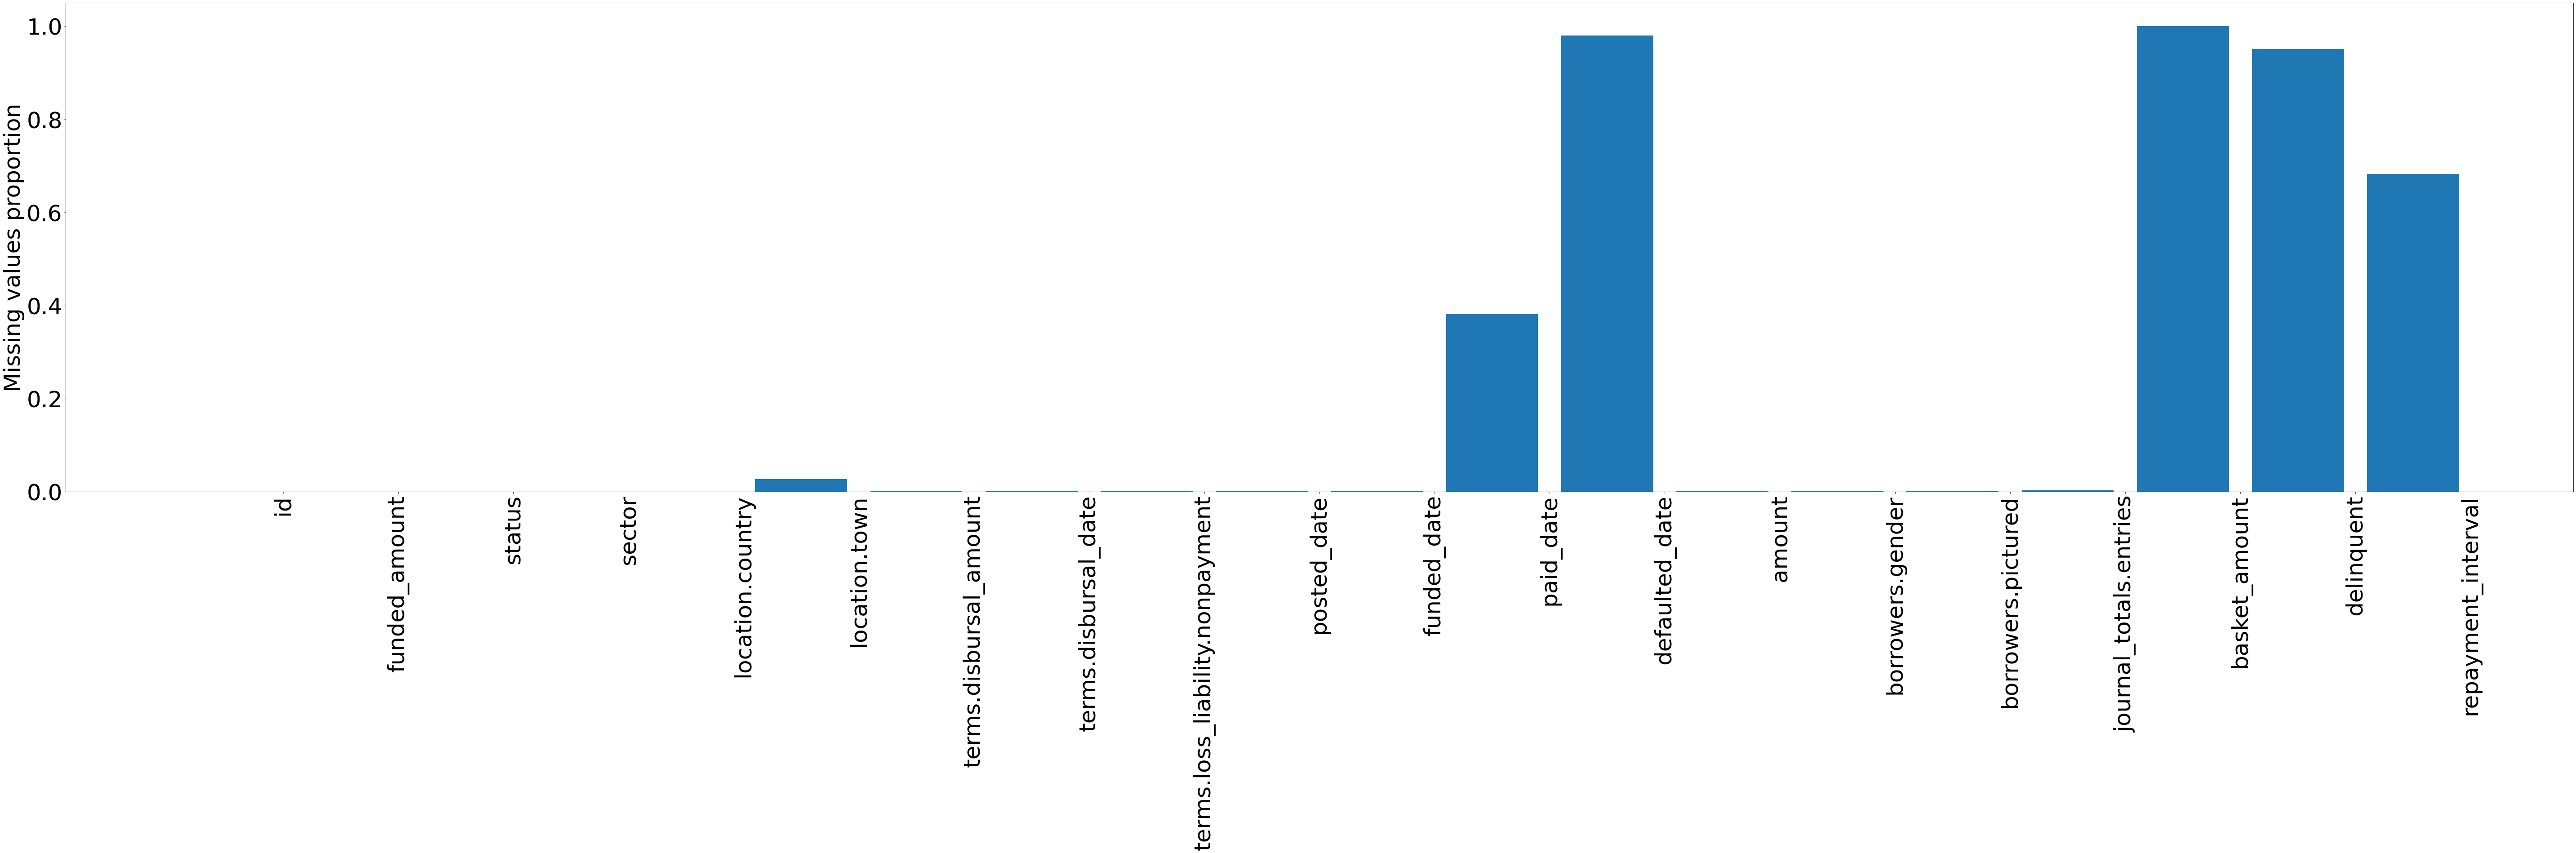

In [274]:
## Missing values visualization
null_counts = resul.isnull().sum()/len(resul)
plt.figure(figsize=(100,20))
plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical', fontsize=50)
plt.yticks(fontsize=50)
plt.ylabel('Missing values proportion', fontsize=50)
plt.bar(np.arange(len(null_counts)),null_counts)

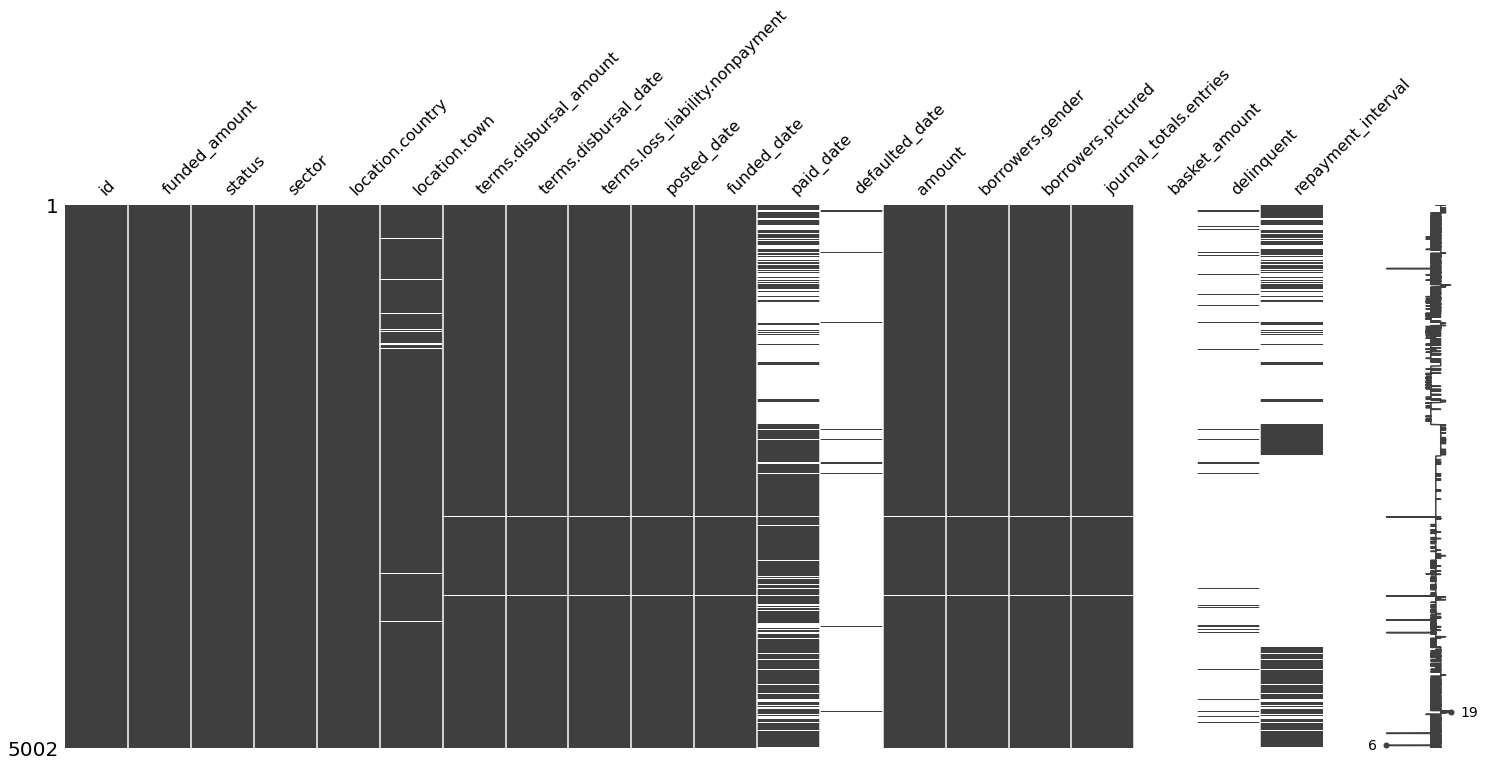

In [275]:
msno.matrix(resul)

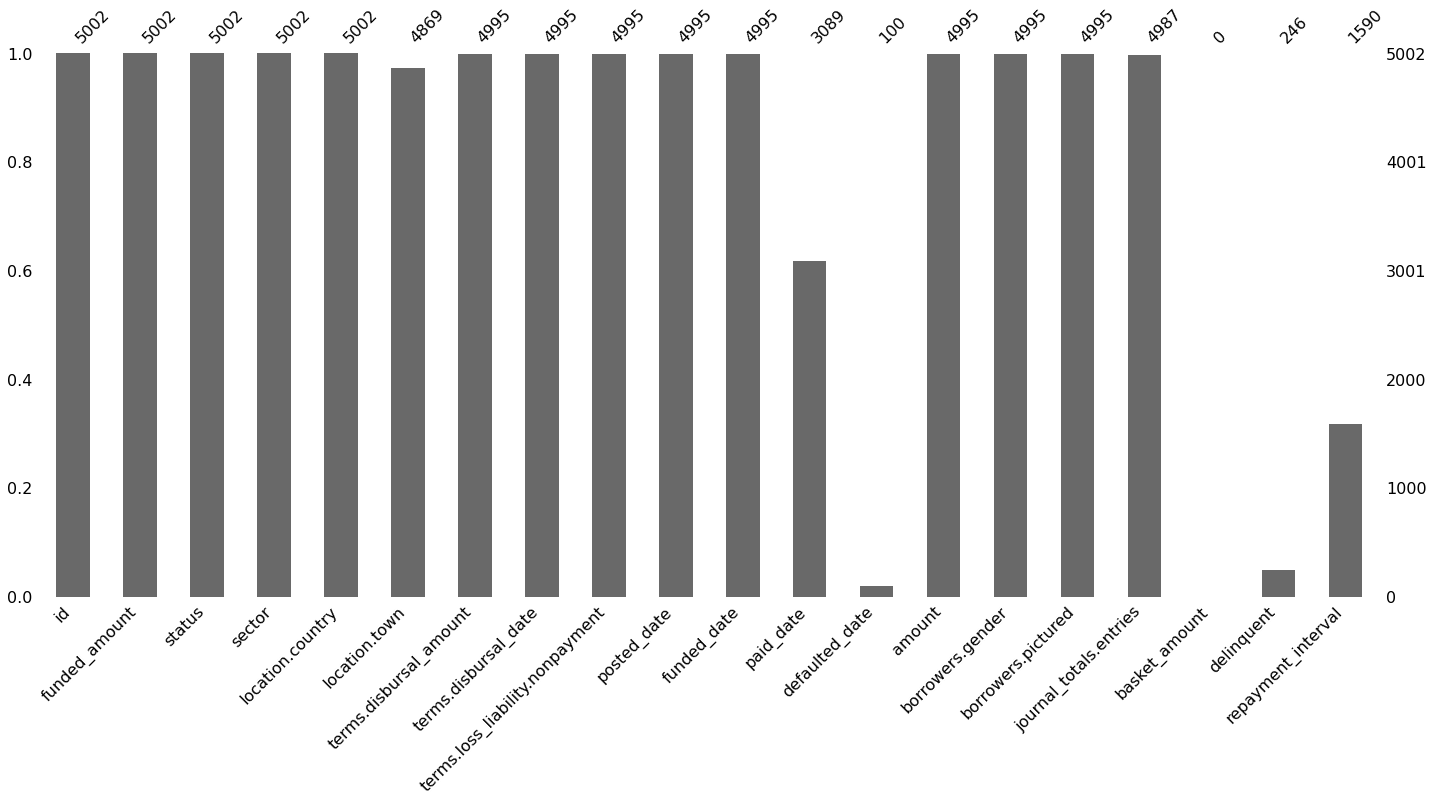

In [276]:
msno.bar(resul)

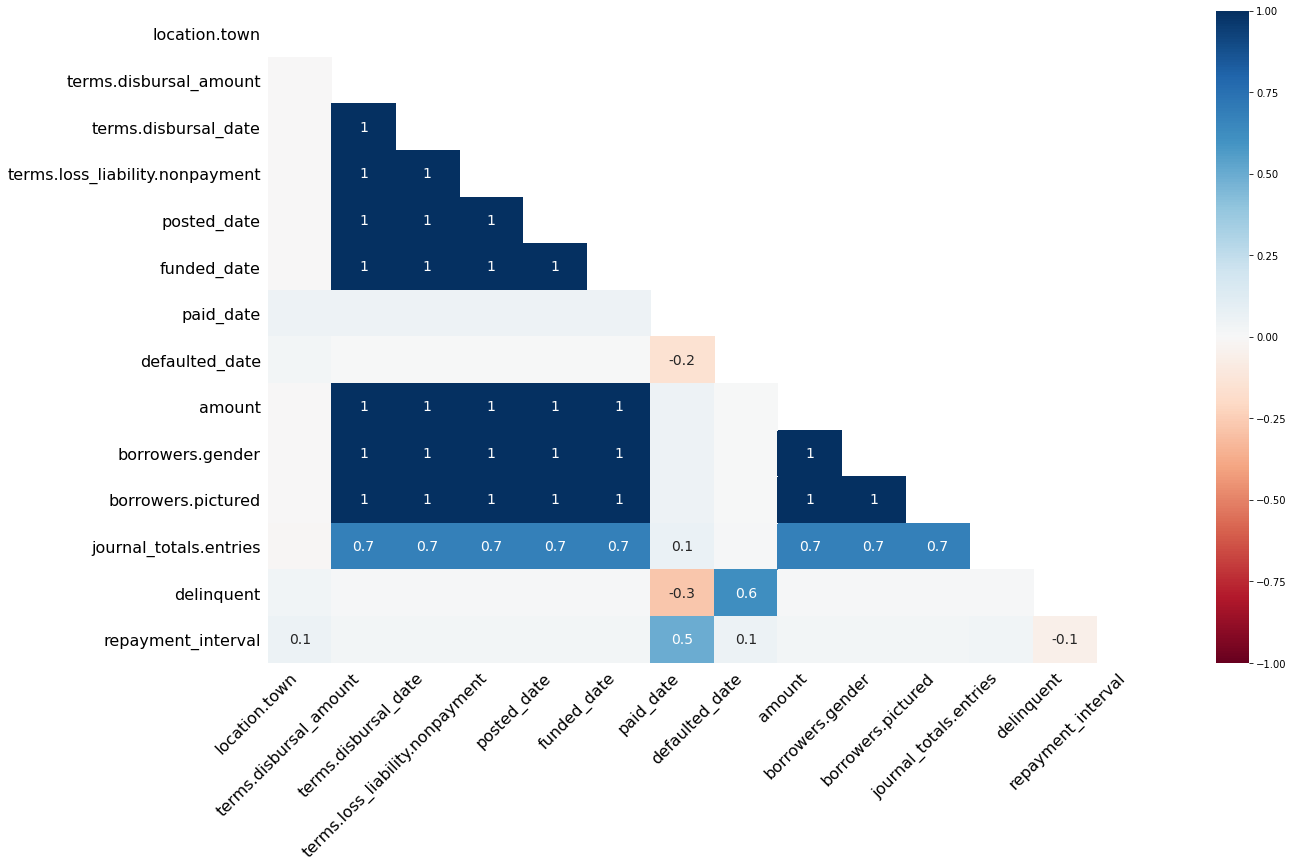

In [277]:
msno.heatmap(resul)

In [278]:
pd.crosstab(resul.status,"freq")

col_0,freq
status,
defaulted,100
in_repayment,1818
paid,3084


In [279]:
resul['close_date'] = np.where(resul["defaulted_date"].isnull(), resul["paid_date"], resul["defaulted_date"] )

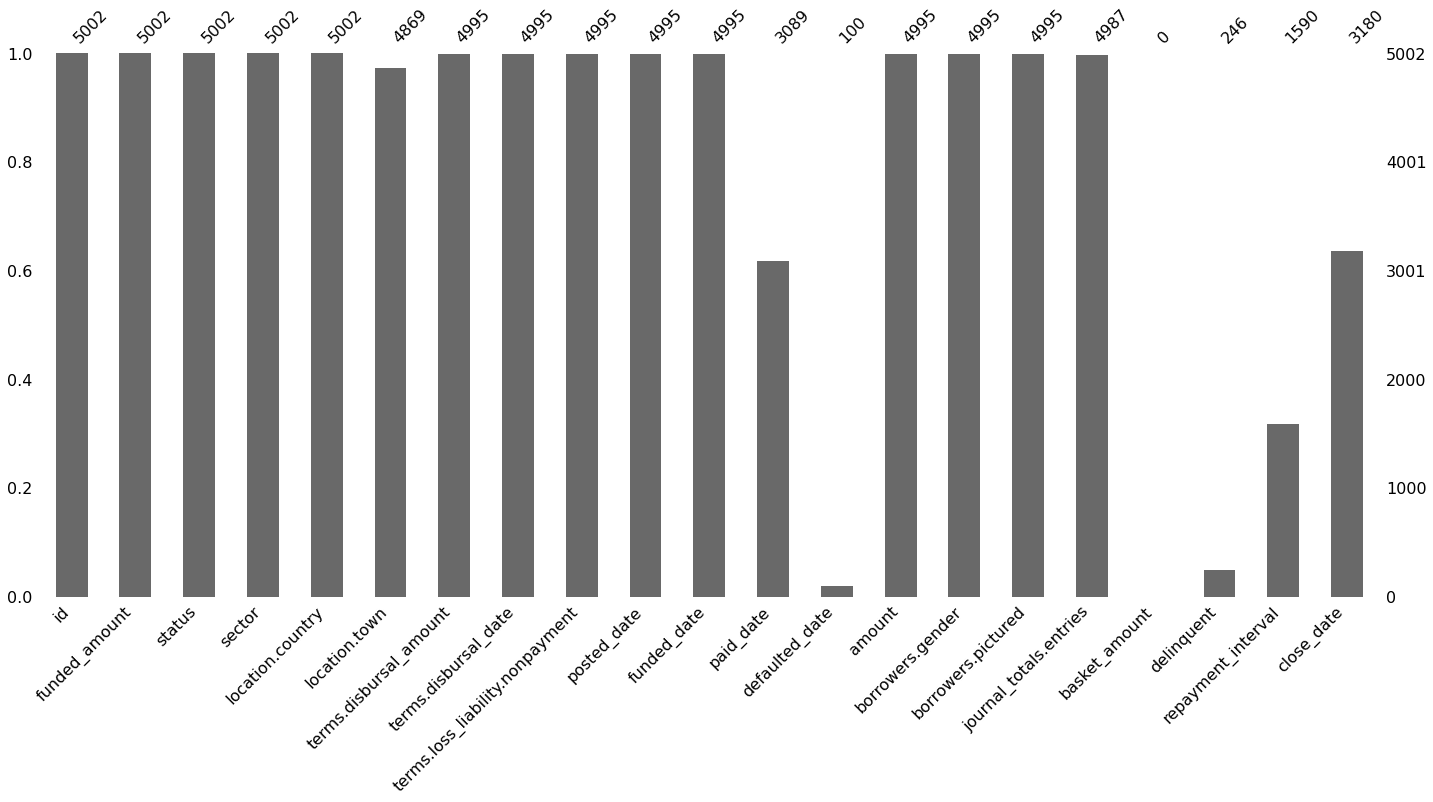

In [280]:
msno.bar(resul)

In [281]:
# We keep only paid and defaulted observations
resul = resul[resul.status != 'in_repayment']

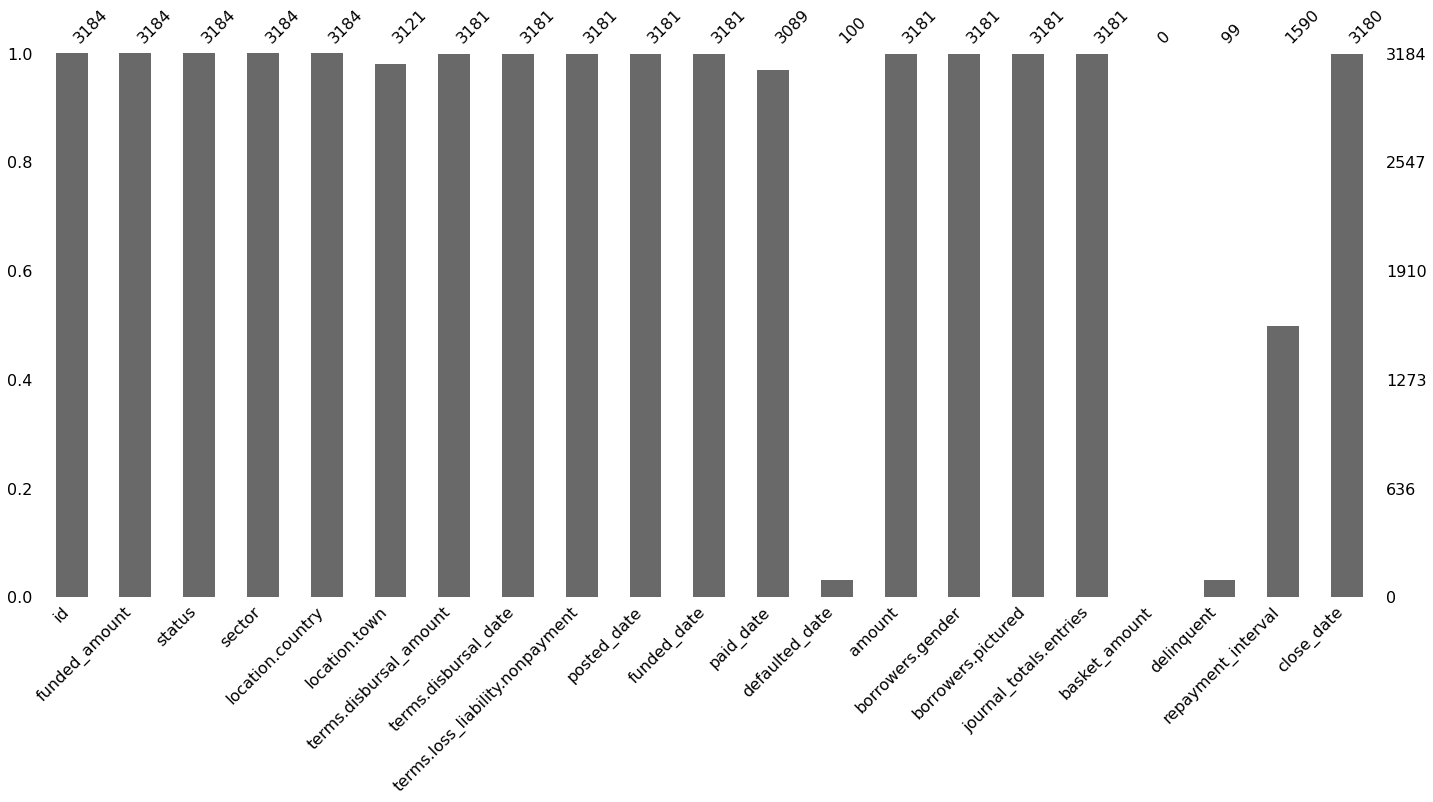

In [282]:
msno.bar(resul)

In [283]:
pd.crosstab(resul.status,resul.delinquent)

delinquent,True,TRUE
status,,
defaulted,49,50


In [284]:
# We drop some variables with too many missing values
var_to_delete = ['basket_amount','repayment_interval','defaulted_date', 'paid_date','delinquent']
resul = resul.drop(var_to_delete, axis=1)

In [285]:
test = resul.dropna(axis=0)
test.shape

(3117, 16)

In [286]:
pd.crosstab(test.status,"freq")
# Only paid observations have missing values 

col_0,freq
status,
defaulted,100
paid,3017


In [287]:
resul = resul.dropna(axis=0)

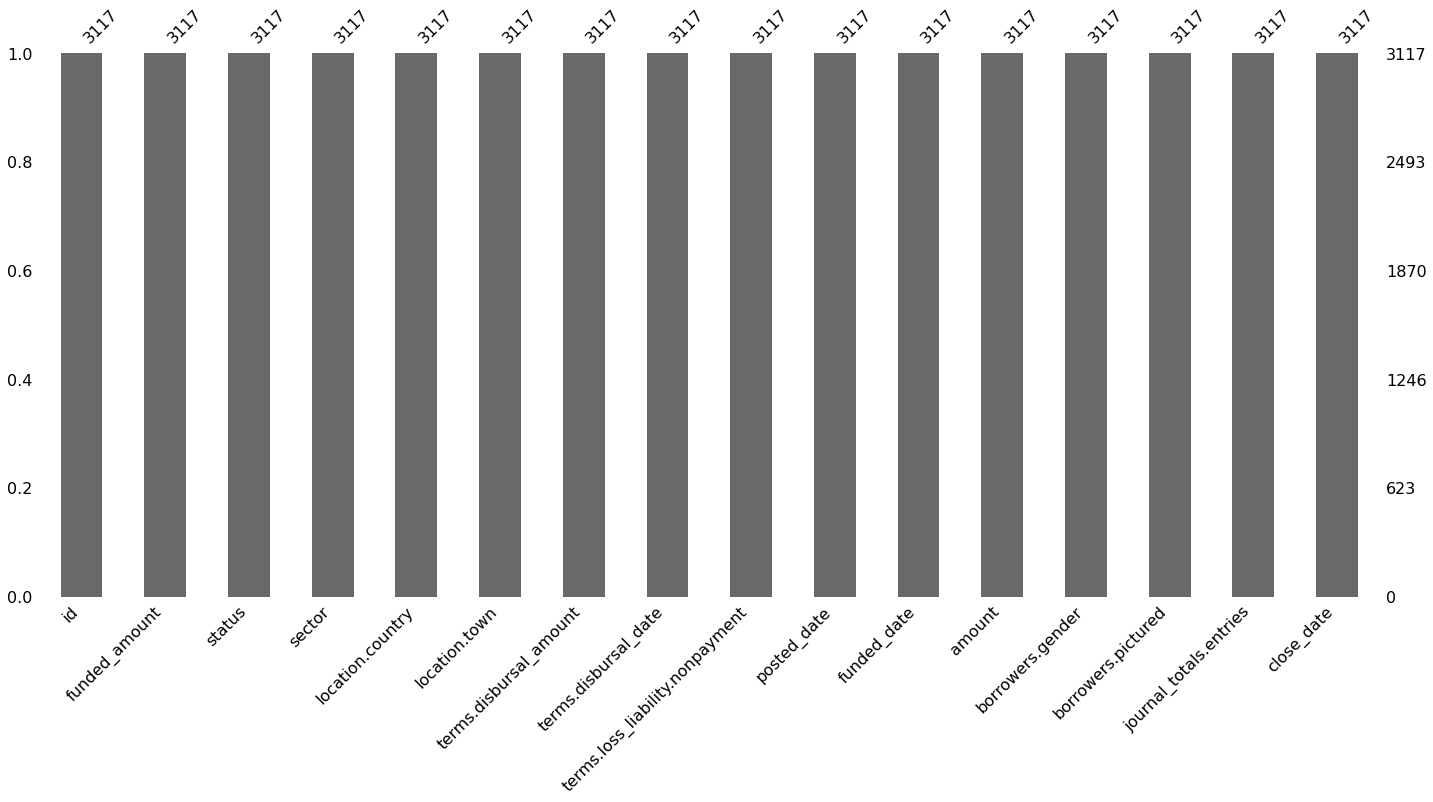

In [288]:
msno.bar(resul)
# we are going to work with this database

### Target variable

In [289]:
pd.crosstab(resul.status,"freq")

col_0,freq
status,
defaulted,100
paid,3017


In [290]:
conditions = [
    (resul.status == 'defaulted'),
    (resul.status == 'paid')
]
values = [1,0]

In [291]:
resul['target'] = np.select(conditions, values)

In [292]:
pd.crosstab(resul.target,"freq")

col_0,freq
target,
0,3017
1,100


In [293]:
resul.head()

,id,funded_amount,status,sector,location.country,location.town,terms.disbursal_amount,terms.disbursal_date,terms.loss_liability.nonpayment,posted_date,funded_date,amount,borrowers.gender,borrowers.pictured,journal_totals.entries,close_date,target
0,156,500,paid,Construction,Nicaragua,Managua,500,14/04/2005,partner,15/02/2006,31/03/2005,50.0,M,True,1.0,16/09/2006,0
1,173,600,defaulted,Construction,Gaza,Rafah,600,14/04/2005,lender,15/02/2006,31/03/2005,50.0,M,True,7.0,11/09/2007,1
2,183,500,paid,Food,Honduras,Siguatepeque,500,14/04/2005,partner,15/03/2006,31/03/2005,35.0,F,True,2.0,21/11/2006,0
4,200,575,paid,Services,Kenya,Ongata Rongai,575,14/04/2005,partner,15/03/2006,31/03/2005,114.0,F,True,2.0,02/05/2007,0
5,213,225,paid,Food,Honduras,Danli,225,14/04/2005,partner,15/03/2006,31/03/2005,40.0,M,True,1.0,28/11/2006,0


In [294]:
resul.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3117 entries, 0 to 5000
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               3117 non-null   object 
 1   funded_amount                    3117 non-null   object 
 2   status                           3117 non-null   object 
 3   sector                           3117 non-null   object 
 4   location.country                 3117 non-null   object 
 5   location.town                    3117 non-null   object 
 6   terms.disbursal_amount           3117 non-null   object 
 7   terms.disbursal_date             3117 non-null   object 
 8   terms.loss_liability.nonpayment  3117 non-null   object 
 9   posted_date                      3117 non-null   object 
 10  funded_date                      3117 non-null   object 
 11  amount                           3117 non-null   float64
 12  borrowers.gender    

In [295]:
resul = resul.drop('terms.disbursal_amount', axis=1)

In [296]:
resul['funded_amount'] = pd.to_numeric(resul['funded_amount'], downcast='float')

# Categorical variables

In [297]:
resul.sector.value_counts()

Food              951
Retail            715
Agriculture       533
Clothing          278
Services          266
Arts               94
Transportation     92
Construction       75
Manufacturing      35
Health             30
Housing            25
Wholesale          11
Personal Use        6
Education           4
Entertainment       2
Name: sector, dtype: int64

In [298]:
categorical_var = ['sector', 'location.country','location.town', 'terms.disbursal_date',
       'terms.loss_liability.nonpayment', 'posted_date', 'funded_date','borrowers.gender', 'borrowers.pictured','close_date']
date_var = ['terms.disbursal_date','posted_date', 'funded_date','close_date']
resul[categorical_var] = resul[categorical_var].astype('category')
resul['borrowers.gender'] = resul['borrowers.gender'].cat.codes
resul['borrowers.pictured'] = resul['borrowers.pictured'].cat.codes
resul['terms.loss_liability.nonpayment'] = resul['terms.loss_liability.nonpayment'].cat.codes

In [299]:
# We can group the sector variable
others = ['Manufecturing', 'Health', 'Housing', 'Wholesale', 'Personal Use', 'Education', 'Entertainment']
resul['sector_cat'] = np.where(resul['sector'].isin(others), "Other", resul['sector'])

In [300]:
# We can also group the country variable
def country_to_continent(country_name):
    while True:
      try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
        break
      except KeyError:
        return 'Unknown'
    
resul['continent'] = resul['location.country'].apply(country_to_continent)

In [301]:
#We can create dummy variables
resul = pd.get_dummies(resul, columns=['sector_cat','continent'], prefix = ['sector','continent'])
resul.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3117 entries, 0 to 5000
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   id                               3117 non-null   object  
 1   funded_amount                    3117 non-null   float32 
 2   status                           3117 non-null   object  
 3   sector                           3117 non-null   category
 4   location.country                 3117 non-null   category
 5   location.town                    3117 non-null   category
 6   terms.disbursal_date             3117 non-null   category
 7   terms.loss_liability.nonpayment  3117 non-null   int8    
 8   posted_date                      3117 non-null   category
 9   funded_date                      3117 non-null   category
 10  amount                           3117 non-null   float64 
 11  borrowers.gender                 3117 non-null   int8    
 12  borrow

In [302]:
resul

,id,funded_amount,status,sector,location.country,location.town,terms.disbursal_date,terms.loss_liability.nonpayment,posted_date,funded_date,amount,borrowers.gender,borrowers.pictured,journal_totals.entries,close_date,target,sector_Agriculture,sector_Arts,sector_Clothing,sector_Construction,sector_Food,sector_Manufacturing,sector_Other,sector_Retail,sector_Services,sector_Transportation,continent_Africa,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,continent_Unknown
0,156,500.0,paid,Construction,Nicaragua,Managua,14/04/2005,1,15/02/2006,31/03/2005,50.00,1,0,1.0,16/09/2006,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,173,600.0,defaulted,Construction,Gaza,Rafah,14/04/2005,0,15/02/2006,31/03/2005,50.00,1,0,7.0,11/09/2007,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,183,500.0,paid,Food,Honduras,Siguatepeque,14/04/2005,1,15/03/2006,31/03/2005,35.00,0,0,2.0,21/11/2006,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
4,200,575.0,paid,Services,Kenya,Ongata Rongai,14/04/2005,1,15/03/2006,31/03/2005,114.00,0,0,2.0,02/05/2007,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
5,213,225.0,paid,Food,Honduras,Danli,14/04/2005,1,15/03/2006,31/03/2005,40.00,1,0,1.0,28/11/2006,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,102400,150.0,paid,Retail,Philippines,Purok 9b Kiwalan. Iligan City,15/04/2009,1,17/04/2009,17/04/2009,7.89,0,0,2.0,15/09/2009,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4995,102453,350.0,paid,Food,Nigeria,Lagos State,01/04/2009,1,17/04/2009,17/04/2009,43.75,0,0,1.0,15/12/2009,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4998,102713,225.0,paid,Agriculture,Philippines,Cebulin. Plaridel. Misamis Occidental,20/03/2009,1,18/04/2009,18/04/2009,28.12,0,0,2.0,15/09/2009,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4999,102744,75.0,paid,Clothing,Philippines,Bacolod. Ozamiz City. Mis. Occ.,31/03/2009,1,18/04/2009,18/04/2009,12.05,0,0,2.0,16/10/2009,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


# Prediction model

## re-sampling

As we saw in statistic of the target variable, we only have 100 defaulted observation,
that is while we are going to re-sample the dataset to have at list the same number of
inrepayment and default.

In [303]:
resul.target.unique()

array([0, 1])

In [304]:
data_def = resul.loc[resul.target==1]
data_rep = resul.loc[resul.target==0]
print('Base repayment : ', data_rep.shape,'\nBase default : ',data_def.shape)

Base repayment :  (3017, 33) 
Base default :  (100, 33)


In [305]:
data_rep = data_rep.sample(n=100, replace = False)

In [306]:
final = data_def.append(data_rep)

In [307]:
pd.crosstab(final.target,'y')

col_0,y
target,
0,100
1,100


# Modelisation

In [308]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.discrete.discrete_model import Probit
from statsmodels.api import Logit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [309]:
Y = final['target']
X = final.drop(['id','target','status','location.town','location.country','sector', 'sector_Agriculture', 'continent_Africa'], axis=1)
X = X.drop(date_var, axis=1)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,random_state=0)

In [310]:
print(X_train.shape)
print(X_test.shape)

(150, 21)
(50, 21)


In [311]:
## Confusion matrix 
logreg = LogisticRegression()
logreg.fit(X_train,Y_train)
Y_pred=logreg.predict(X_test)
cnf_matrix = metrics.confusion_matrix(Y_test,Y_pred)
cnf_matrix

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([[23,  4],
       [ 3, 20]])

Text(0.5, 257.44, 'Predicted label')

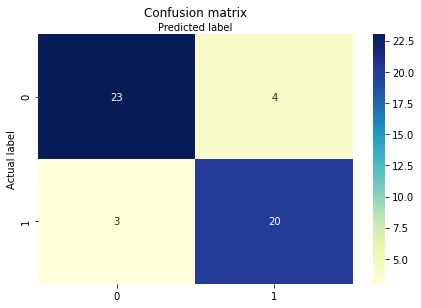

In [312]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [313]:
print("Accuracy:",metrics.accuracy_score(Y_test,Y_pred))
print("Precision:",metrics.precision_score(Y_test,Y_pred))
print("Recall:",metrics.recall_score(Y_test,Y_pred))

Accuracy: 0.86
Precision: 0.8333333333333334
Recall: 0.8695652173913043


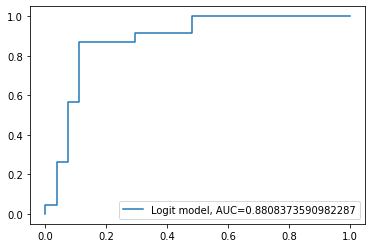

In [236]:
# ROC Curve
Y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_pred_proba)
auc = metrics.roc_auc_score(Y_test, Y_pred_proba)
plt.plot(fpr,tpr,label="Logit model, AUC="+str(auc))
plt.legend(loc=4)
plt.show()

# Statistique Descriptive

In [ ]:
data_loan.describe()

,funded_amount,paid_amount,amount
count,1918.000000,1818.000000,1914.000000
mean,699.270081,339.734680,76.386176
std,616.164062,359.882385,107.388272
min,50.000000,1.560000,0.180000
25%,325.000000,109.625000,27.780000
50%,550.000000,240.000000,50.300000
75%,925.000000,447.082520,84.380000
max,10000.000000,4353.129883,1323.170000


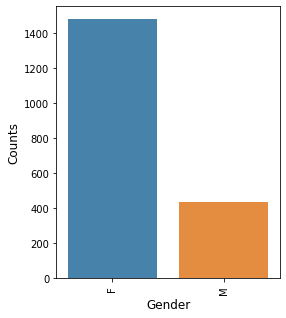

In [ ]:
label_counts = data_loan['borrowers.gender'].value_counts()
plt.figure(figsize = (4,5))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)

plt.xticks(rotation = 'vertical')
plt.xlabel('Gender', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

In [ ]:
data_loan.groupby('target').funded_amount.describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,100.0,621.500000,357.725128,75.0,300.0,587.5,900.0,1400.0
1,1818.0,703.547852,627.078064,50.0,350.0,550.0,925.0,10000.0


In [ ]:
data_loan.groupby('target').paid_amount.describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1818.0,339.73468,359.882385,1.56,109.625,240.0,447.082504,4353.129883


In [ ]:
data_loan.groupby('target').amount.describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,100.0,71.186100,47.282314,6.49,30.0,66.5,100.0000,240.00
1,1814.0,76.672839,109.748240,0.18,27.5,50.0,84.2475,1323.17


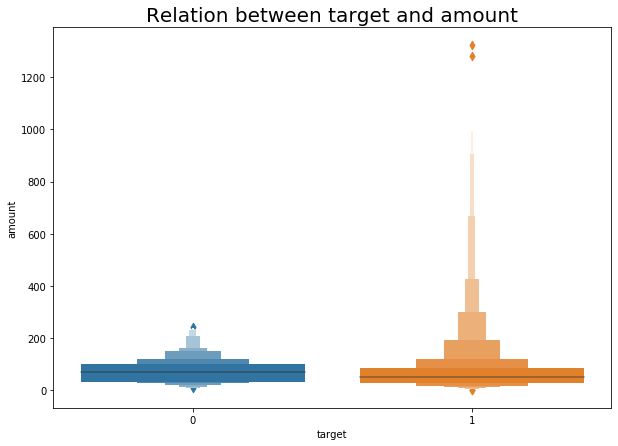

In [ ]:
plt.rcParams['figure.figsize'] = (10, 7)
sns.boxenplot(x = data_loan['target'], y = data_loan['amount'])
plt.title('Relation between target and amount', fontsize = 20)
plt.show()

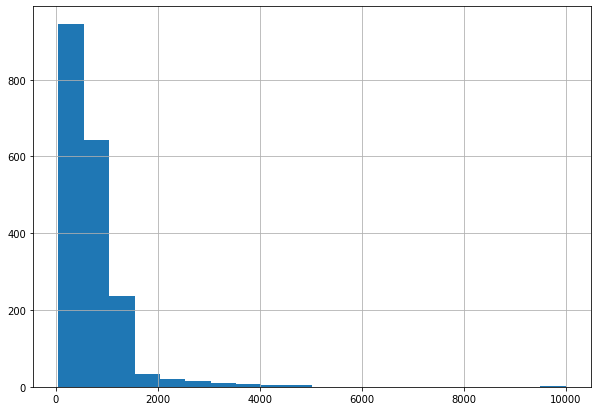

In [ ]:
data_loan.funded_amount.hist(bins = 20)

In [ ]:
from sklearn import preprocessing

In [ ]:
scaler = preprocessing.Normalizer().fit(data_loan['funded_amount'].dropna(how = "any").head(1000))
X1 = scaler.transform(data_loan['funded_amount'].dropna(how = "any").head(1000))


ValueError: Expected 2D array, got 1D array instead:
array=[  600.   300.   700.   825.   700.   300.   600.   300.  1075.   375.
   400.   325.   800.  1000.   650.  1000.  1000.   425.   575.   400.
  1000.   275.  1000.   800.   625.   375.   325.   650.  1450.   500.
   425.  1075.   450.   525.   525.  1200.   425.   125.  3000.  1400.
   550.  1000.  1000.   325.   625.  1000.   975.   325.   600.  3925.
   250.   400.   150.   475.   500.   600.   150.   500.  1075.   275.
   150.   150.   350.  1125.   800.   275.  2325.   375.   625.   425.
   800.   800.   500.   700.  1075.   375.  1125.   625.   325.   950.
   775.   850.   525.  1200.  1050.   225.   500.   625.   725.  1050.
  1025.   700.   225.   750.   575.   925.   525.  2425.   825.  1000.
  1200.  1575.  1150.   125.   950.   500.   900.   500.  1050.   900.
  1000.   325.   200.  1850.   500.   700.   500.   875.   925.   875.
   875.   800.   900.   875.   550.   525.   525.   300.   225.   350.
   350.  2000.   800.  1000.   475.  1025.   625.   500.  1200.  1000.
   450.  1150.   650.  1000.   750.   350.   350.   225.  1000.  1750.
   500.   150.   150.  1000.  1000.   425.   350.   750.   550.   375.
   825.  1250.  1000.   925.   350.   475.   350.   775.   350.  1200.
   775.  1175.   375.   700.   450.  1125.  1000.  1000.  2700.  1000.
  1250.   725.   325.   225.   500.   250.   675.   750.   225.  1125.
  1075.   550.   425.   425.   525.   300.  1200.   975.   400.   250.
   400.   325.   125.   700.   200.   275.   275.   850.   525.   275.
   600.   225.   700.   700.   500.   500.   650.   750.   350.   350.
   500.   575.   175.  1000.   425.   425.   650.   225.  1025.   425.
   550.   325.   550.   675.   625.   700.   700.   500.   425.   950.
   400.  4175.   225.   525.   425.  1000.  1000.  1500.  1000.  1000.
  1075.   400.   525.  2000.   200.   325.   375.   375.   375.  1125.
   375.   375.   375.   375.   625.   600.  1200.  1000.   475.   275.
   775.   700.   600.   425.   850.   850.   250.  1175.   500.   850.
   550.   475.   925.  1200.   150.   375.   325.   125.   400.   500.
  1875.  1150.   550.  2000.   775.  1200.   250.  3150.  1050.   425.
   975.   800.   875.   475.   700.   350.   775.   775.  1075.  1075.
  1025.   525.   400.   250.   300.   525.   350.   650.   475.   700.
   525.  1975.   475.   475.   500.   150.   650.  1075.   550.   475.
   650.   275.   250.   675.   525.   350.   225.   675.   650.  1075.
   175.   675.   150.   500.   550.   675.   675.   675.   275.   675.
   550.   325.   800.   350.  1100.   225.   425.   275.   300.   325.
   150.   500.  3550.   125.   325.   425.   200.  1100.   600.   575.
   800.  1200.   925.   600.   375.   850.   500.  2000.  1450.   525.
   325.   350.   250.   125.   875.   275.   275.   275.  5000.   350.
   525.   300.  1200.  1000.   850.   225.   475.   250.   300.   750.
   275.   250.   700.   650.   450.   500.   200.   225.   275.   600.
   750.  1000.   625.   400.   775.   200.    75.   275.  1200.   275.
   275.   650.   375.   375.   250.  1000.  1200.  1000.   800.   250.
   650.  1025.   550.  1200.  2875.  1200.   500.  2450.  1025.   200.
   900.   250.   775.  1000.   475.  1075.   900.   525.   750.   225.
   150.   250.  1125.  1175.   225.   525.   125.   575.   900.   225.
   225.  1225.   250.   125.   950.   550.   800.   500.  3000.   225.
   150.   225.   375.   650.   500.   225.   700.  1000.   325.   400.
   900.   275.   975.  1000.   875.   275.   425.   325.   650.   450.
   500.   350.   125.   275.  1550.   250.   900.  1000.   500.   150.
   125.   125.   175.   400.   300.  1500.   175.   500.   425.  1000.
   250.   150.   450.   250.   100.   200.   700.   925.   375.    75.
   425.  2075.   650.  1025.   850.  1200.  1075.   125.   425.   200.
   700.   550.   725.   925.  1025.   225.    50.   225.   750.   650.
   600.   525.   700.   125.   800.   550.   225.   700.  3100.   425.
   750.   800.   525.   625.   575.   225.  1800.   450.  1100.  2000.
  4500.   350.   875.   125.   500.   800.   575.   400.   150.  1150.
   675.   675.   325.   300.  1000.   800.   525.  1025.   400.   350.
   325.    75.   400.   300.   125.   425.  1100.   375.  1050.   550.
   400.   800.   700.   700.   300.   250.  1150.  1150.   200.   350.
   550.   250.   425.   350.   225.   575.   525.   200.   500.   825.
   425.   300.   425.   500.   775.   650.  2000.   525.   700.   750.
   500.   425.  1500.   775.   250.  2000.   525.  2350.   650.  1125.
   400.   350.   300.   125.   700.   325.  1150.  1000.   500.   225.
   175.  1200.  1150.   925.   925.   800.   225.  1775.   300.   225.
   425.   600.   325.   600.   700.  3825.  3275.   550.   125.   125.
   125.   225.  1875.   350.   275.   275.   300.   375.   675.   700.
   925.  1600.   625.   275.  1175.   700.   700.  1000.   500.   225.
   125.   125.   125.   800.   800.   525.   350.   650.   750.  4975.
  3550.   525.   350.   950.   350.   425.  3000.   900.  1375.   375.
   425.   525.   125.   125.   325.   900.  2500.   900.   300.   950.
    75.  1075.   450.   575.  2575.   275.   725.   175.   125.   150.
   375.   800.   825.   700.   625.   325.   175.   675.   850.   700.
   800.   425.   575.   225.   500.   575.   750.  2325.   150.   525.
   350.   825.   325.   225.   125.   150.   550.   125.   175.   100.
   425.   300.   825.   150.    75.   450.   450.   325.   975.   150.
   275.   300.   825.   750.   575.   575.   900.  1025.  2875.   975.
   800.   225.   325.  1225.   700.  1200.  1125.   225.   250.   500.
   800.   900.   700.   350.   600.   525.   350.   550.   300.   425.
   125.  1150.  1500.  1025.   150.  1200.  1200.  1000.   175.   400.
   850.   675.   250.   475.   550.   700.   400.   650.   300.   125.
   625.   500.   750.   300.   300.   225.   125.   125.   625.   425.
  1175.   150.   125.   350.   175.  3000.   700.  1150.   700.   800.
   150.  1500.   425.   700.   175.   425.   700.   700.   800.   600.
  1750.  1750.   800.   700.   625.   175.   175.   900.   350.  1000.
  3325.   350.   300.  1050.   350.   700.   750.   225.   500.  1200.
   150.   625.   475.   200.   400.   125.   300.   550.   375.   250.
   500.   125.   800.   400.  1025.   100.  1050.   225.   700.  2200.
   175.   775.   350.   500.  3050.   125.   250.  1075.   550.   125.
   350.   125.   450.   900.   275.   425.   125.   125.   475.   350.
   550.   975.  1050.  1275.   225.   175.   275.   325.   675.   350.
   300.   400.   450.   650.   425.   675.   300.   250.   150.   125.
   125.   125.   550.  1075.   275.   225.  1000.   550.   975.   425.
  1775.   325.   700.  1000.   125.   125.   425.   175.   125.  1100.
   675.  1050.   350. 10000.  1075.   700.   675.   350.   275.   250.
   125.   125.   550.   175.   125.   375.   125.   225.   425.   125.
   125.   575.   450.   475.   850.   350.   350.   650.    75.   475.
   300.   875.   125.   100.   150.    75.   225.   700.   700.   375.
   450.   650.  2375.   675.   650.  2025.   775.  3150.  3425.  3275.
   300.  1200.   275.   125.  1500.   125.   275.   150.   275.  1075.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.